<h3 align="center">Data Analytics</h3> 
<h3 align="center">Course Assignment N.07: New Channels</h3> 
<h3 align="center">Academic Year 2023</h3> 

**Done by:**
Yusuke Sugihara,
Maria Camila Millan

### import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pprint
import sklearn.datasets as datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.datasets import fetch_20newsgroups

from collections import Counter # Visualizing class Distribution
import matplotlib.cm as cm # color map


# perform more Pre-processing steps
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from pprint import pprint


from gensim.models import word2vec
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
from itertools import cycle
import time
from gensim.models import word2vec

In [2]:
from pprint import pprint
print(os.getcwd())
print(os.listdir())
path_dataset = "/Users/yusuke_sugihara/DA_Project/07_news_Channels/"
# print(os.listdir(path_dataset))


/Users/yusuke_sugihara/DA_Project/DA_Project2
['data_analytics_project2.ipynb', '.DS_Store', '01_data_description.ipynb', 'png', 'README.md', '.git']


**NOTE**: Since our dataset is exactly the same as https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset, we will use the  [```The sklearn.datasets.fetch_20newsgroups function```](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) so that we can efficiently analyze the dataset.




## 1. Preprocessing - Data Cleaning 

We can see that there is unnecessary information such as header and footer quotes in the raw dataset below.(e.g. header, footer, quotes)

In [3]:
raw_dataset = fetch_20newsgroups(data_home = path_dataset, subset='all', shuffle=False)
print(raw_dataset.data[1])

From: gnelson@pion.rutgers.edu (Gregory Nelson)
Subject: Thanks Apple: Free Ethernet on my C610!
Article-I.D.: pion.Apr.6.12.05.34.1993.11732
Organization: Rutgers Univ., New Brunswick, N.J.
Lines: 26


	Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wouldn't come up!
	The hard drive also has an annoying high pitch

Therefore, I will remove those unneccesary information with one parameter called "remove" in the ``sklearn.datasets.fetch_20newsgroups¶``

### All dataset

In [4]:
# Remove the headers, footers, and quotes from the documents.
all_dataset = fetch_20newsgroups(
    data_home=path_dataset,
    remove=("headers", "footers", "quotes"), 
    subset="all",
    shuffle=True,
    random_state=42,
)

labels = all_dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(all_dataset.data)} documents - {true_k} categories")


18846 documents - 20 categories


### Train dataset

In [5]:
# Remove the headers, footers, and quotes from the documents.
train_dataset = fetch_20newsgroups(
    data_home=path_dataset,
    remove=("headers", "footers", "quotes"), 
    subset="train",
    shuffle=True,
    random_state=42,
)

labels = train_dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(train_dataset.data)} documents - {true_k} categories")

11314 documents - 20 categories


### Test Dataset

In [6]:
# # Remove the headers, footers, and quotes from the documents.
# test_dataset = fetch_20newsgroups(
#     data_home=path_dataset,
#     remove=("headers", "footers", "quotes"), 
#     subset="test",
#     shuffle=True,
#     random_state=42,
# )

# labels = test_dataset.target
# unique_labels, category_sizes = np.unique(labels, return_counts=True)
# true_k = unique_labels.shape[0]

# print(f"{len(test_dataset.data)} documents - {true_k} categories")

#### Check if we can remove those unnecessary information from each document.

In [7]:
for i in range(2):
    doc = all_dataset.data[i]
    category = all_dataset.target_names[all_dataset.target[i]]
    print("The {}-th sent of {}: {}".format(i+1, category, doc))
    print("==================================================\n")

The 1-th sent of rec.sport.hockey: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!



The 2-th sent of comp.sys.ibm.pc.hardware: My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

#### Now those unnecesarry information were actually eliminated from the origina doc

### Check all categories for both train dataset and test one
I can see there are 20 categories in total in the dataset.

In [8]:
pprint(list(train_dataset.target_names))
pprint(len(train_dataset.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
20


In [9]:
# pprint(list(test_dataset.target_names))
# pprint(len(test_dataset.target_names))

#### Now we were able to make sure if both train dataset and test dataset have the same categories, which 20 categories in total.

The real data lies in the filenames and target attributes. The target attribute is the integer index of the category:

In [10]:
print(all_dataset.filenames[:3]) # file names
print(f'labels: {all_dataset.target[:3]}') # # labels for clustering evaluation 
print(all_dataset.data[:3]) # data  

['/Users/yusuke_sugihara/DA_Project/07_news_Channels/20news_home/20news-bydate-test/rec.sport.hockey/54367'
 '/Users/yusuke_sugihara/DA_Project/07_news_Channels/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60215'
 '/Users/yusuke_sugihara/DA_Project/07_news_Channels/20news_home/20news-bydate-train/talk.politics.mideast/76120']
labels: [10  3 17]
["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed no

### Check how many documents there are in the all dataset.

In [11]:
print(len(all_dataset.data), len(all_dataset.target)) 
print(type(all_dataset.data), type(all_dataset.target))
# print(all_dataset.target_names)

18846 18846
<class 'list'> <class 'numpy.ndarray'>


In [12]:
print(len(train_dataset.data), len(train_dataset.target)) 
print(type(train_dataset.data), type(train_dataset.target))
# print(train_dataset.target_names)

11314 11314
<class 'list'> <class 'numpy.ndarray'>


In [13]:
# print(len(test_dataset.data), len(test_dataset.target)) 
# print(type(test_dataset.data), type(test_dataset.target))
# # print(test_dataset.target_names)

### Distribution of the number of docoments for each category

#### Train dataset

(7, 4, 1, 14, 16, 13, 3, 2, 8, 19, 6, 0, 12, 5, 10, 9, 15, 17, 18, 11)
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
(594, 578, 584, 593, 546, 594, 590, 591, 598, 377, 585, 480, 591, 593, 600, 597, 599, 564, 465, 595)


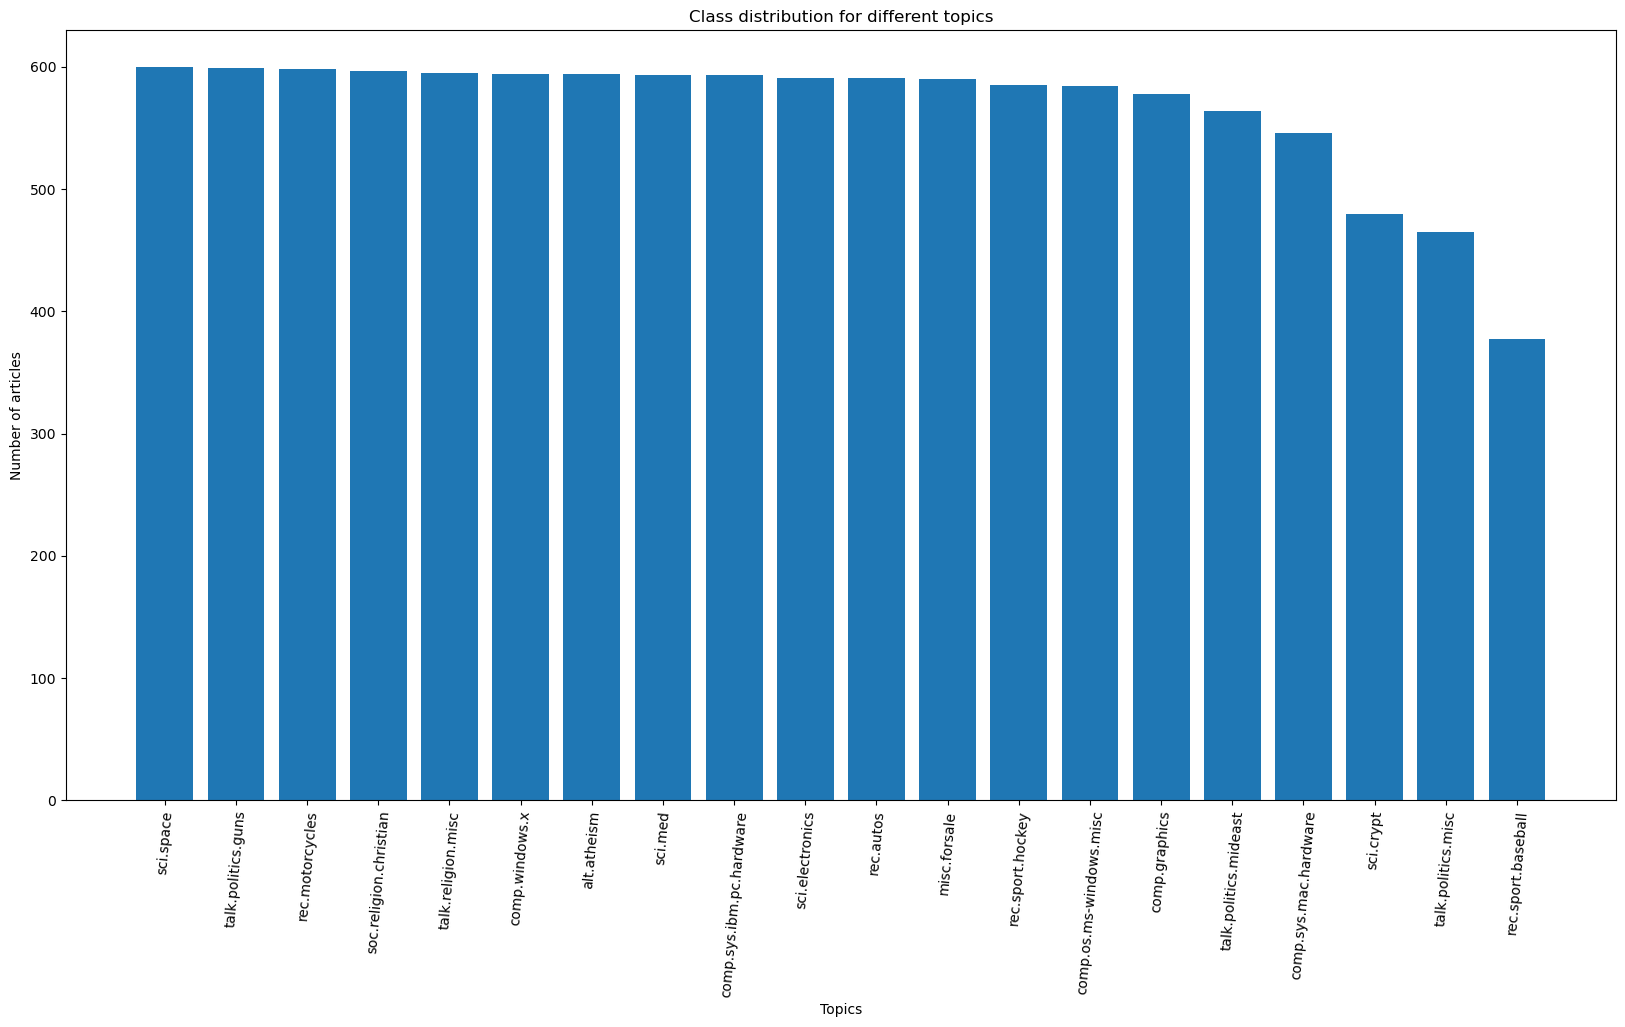

In [14]:
label_20, values = zip(*Counter(train_dataset.target).items())
print(label_20)
print(train_dataset.target_names)
print(values)

indexes = np.argsort(values)[::-1]
label_20 = np.array(train_dataset.target_names)[indexes]
val = np.array(values)[indexes]

plt.figure(figsize=(20, 10))
plt.bar(label_20, val)
plt.xticks(rotation=85)
plt.xlabel('Topics')
plt.ylabel('Number of articles')
plt.title('Class distribution for different topics')
plt.show()


In [15]:
# label_20, values = zip(*Counter(test_dataset.target).items())
# print(label_20)
# print(test_dataset.target_names)
# print(values)

# indexes = np.argsort(values)[::-1]
# label_20 = np.array(test_dataset.target_names)[indexes]
# val = np.array(values)[indexes]

# plt.figure(figsize=(20, 10))
# plt.bar(label_20, val)
# plt.xticks(rotation=85)
# plt.xlabel('Topics')
# plt.ylabel('Number of articles')
# plt.title('Class distribution for different topics')
# plt.show()

# Quantifying the quality of clustering results¶

In this section we define a function to score different clustering pipelines using several metrics.

Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters. Examples of such metrics are the following:

homogeneity, which quantifies how much clusters contain only members of a single class;

completeness, which quantifies how much members of a given class are assigned to the same clusters;

V-measure, the harmonic mean of completeness and homogeneity;

Rand-Index, which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment;

Adjusted Rand-Index, a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation.

If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

In [16]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

# K-means clustering on text features¶

Two feature extraction methods are used in this example:

TfidfVectorizer uses an in-memory vocabulary (a Python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.

HashingVectorizer hashes word occurrences to a fixed dimensional space, possibly with collisions. The word count vectors are then normalized to each have l2-norm equal to one (projected to the euclidean unit-sphere) which seems to be important for k-means to work in high dimensional space.

Furthermore it is possible to post-process those extracted features using dimensionality reduction. We will explore the impact of those choices on the clustering quality in the following

### Feature Extraction using TfidfVectorizer¶

We first benchmark the estimators using a dictionary vectorizer along with an IDF normalization as provided by TfidfVectorizer.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(train_dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")


vectorization done in 0.947 s
n_samples: 11314, n_features: 17797


After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5), the resulting number of unique terms n_features is around 8,000. We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries devided by the total number of elements.

In [18]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.003


We find that around 0.7% of the entries of the X_tfidf matrix are non-zero.

### Clustering sparse data with k-means¶

As both KMeans and MiniBatchKMeans optimize a non-convex objective function, their clustering is not guaranteed to be optimal for a given random init. Even further, on sparse high-dimensional data such as text vectorized using the Bag of Words approach, k-means can initialize centroids on extremely isolated data points. Those data points can stay their own centroids all along.

The following code illustrates how the previous phenomenon can sometimes lead to highly imbalanced clusters, depending on the random initialization:

In [19]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements asigned to each cluster: [ 531  469  899  180  545  265  473   96  587  341  446  454  181  120
  221  271  411 3795  244  785]
Number of elements asigned to each cluster: [    1 11267     1     2     2     1     8     1    10     2     1     1
     8     2     1     1     1     1     1     2]
Number of elements asigned to each cluster: [    1     1     1     1 11270     1     3     1     1     2     1     1
    10     1    10     1     1     2     1     4]
Number of elements asigned to each cluster: [    2     1     1 11283     1     1     1     1     1     2     3     1
     1     1     5     1     5     1     1     1]
Number of elements asigned to each cluster: [   2    1    2    3    1    1    1    1    1   18    1    1    1 2456
    1   53    1 8766    1    2]

True number of documents in each category according to the class labels: [480 584 591 590 578 593 585 594 598 597 600 595 591 594 593 599 546 564
 465 377]


To avoid this problem, one possibility is to increase the number of runs with independent random initiations n_init. In such case the clustering with the best inertia (objective function of k-means) is chosen.

In [20]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 1.13 ± 0.32 s 
Homogeneity: 0.249 ± 0.105
Completeness: 0.395 ± 0.052
V-measure: 0.281 ± 0.104
Adjusted Rand-Index: 0.062 ± 0.029
Silhouette Coefficient: 0.006 ± 0.002


All those clustering evaluation metrics have a maximum value of 1.0 (for a perfect clustering result). Higher values are better. Values of the Adjusted Rand-Index close to 0.0 correspond to a random labeling. Notice from the scores above that the cluster assignment is indeed well above chance level, but the overall quality can certainly improve.

Keep in mind that the class labels may not reflect accurately the document topics and therefore metrics that use labels are not necessarily the best to evaluate the quality of our clustering pipeline.

In [21]:
def pre_processing(docs):
    stopwords = set(STOPWORDS)
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+") # remove punctuations
    # en_stop = stopwords('en') # 
    for doc in docs:
        raw_text = doc.lower()
        # tokenization
        tokens_text = tokenizer.tokenize(raw_text)
        # remove stopwords
        stopped_tokens_text = [i for i in tokens_text if not i in stopwords]
        # remove digis and one-charcter word
        doc = [token for token in stopped_tokens_text if not token.isnumeric()]
        doc = [token for token in stopped_tokens_text if len(token) > 1]
        # you could always add some new preprocessing here
        yield doc

In [22]:
# Preprocess all the documents in the corpus
Vocab_v1 = list(pre_processing(train_dataset.data))

In [23]:
# verify length of the clean corpus and print a sample clean tokenized document
print(len(Vocab_v1))
print(Vocab_v1[0])
print(Vocab_v1[1])

11314
['wondering', 'anyone', 'enlighten', 'car', 'saw', 'day', '2-door', 'sports', 'car', 'looked', 'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'e-mail']
['fair', 'number', 'brave', 'souls', 'upgraded', 'si', 'clock', 'oscillator', 'shared', 'experiences', 'poll', 'please', 'send', 'brief', 'message', 'detailing', 'experiences', 'procedure', 'top', 'speed', 'attained', 'cpu', 'rated', 'speed', 'add', 'cards', 'adapters', 'heat', 'sinks', 'hour', 'usage', 'per', 'day', 'floppy', 'disk', 'functionality', '800', 'floppies', 'especially', 'requested', 'will', 'summarizing', 'next', 'two', 'days', 'please', 'add', 'network', 'knowledge', 'base', 'done', 'clock', 'upgrade', 'answered', 'poll', 'thanks']


In [24]:
# train the Word2Vec model on the cleaned sentences
start = time.time()
# Set values for various parameters
# Dimensionality of the hidden layer representation
num_features = 100
# Minimum word count to keep a word in the vocabulary    
min_word_count = 20
# Context window size (on each side)
context = 5
# Downsample setting for frequent words                                                             
downsampling = 1e-3  

# Initialize and train the model. 
print("Training model...");
w2v_model = word2vec.Word2Vec(Vocab_v1, vector_size=num_features, min_count=min_word_count, window=context, sample=downsampling)
# calling init_sims to make the model more memory efficient by normalizing the vectors in-place.
# w2v_model.init_sims(replace=True);
# Save the model
model_name = "model_full_20newsGroup";
w2v_model.save(model_name);
print('Total time: {:.2f} secs'.format(time.time() - start))


AttributeError: 'builtin_function_or_method' object has no attribute 'time'

In [ ]:
# Obtain the Word Vectors for each word in the vocab, stored in a variable called ‘syn0’
word_vectors = w2v_model.wv.vectors;
print(word_vectors[0].shape)
# print word vector for the first word: 100-element vector with values
word_vectors[0]

In [ ]:
# print length of word vectors
len(word_vectors)

In [ ]:
# cluster the words using KMeans
num_clusters = 20
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters)
clusters = kmeans_clustering.fit_predict(word_vectors)
centers = kmeans_clustering.cluster_centers_
centroid_map = dict(zip(w2v_model.wv.index_to_key, clusters))


In [ ]:
# get words in each cluster that are closest to the cluster center
# initialize a KDTree on the word vectors, and query it for the Top K words on each cluster center.
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];
    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df

In [ ]:
# get the top words and print the first 2 in each cluster:
top_words = get_top_words(w2v_model.wv.index_to_key, 5000, centers, word_vectors);
top_words[:2]

In [ ]:
# Create a word cloud with the words of a cluster and print and save them.
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num)]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

In [ ]:
# call on each cluster, and pass in a different color scheme in each iteration to distinguish them.
from wordcloud import WordCloud 
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(0, 20):
    col = next(cmaps)
    display_cloud(i, col)